# Hcopilot

## Set up Working Directory and Environment Variables

In [15]:
import os, dotenv

def find_project_root(start_dir="."):
    current_dir = os.path.abspath(start_dir)
    while True:
        if os.path.exists(os.path.join(current_dir, ".project_root")):
            return current_dir
        
        parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
        
        if parent_dir == current_dir:
            raise FileNotFoundError("Project root not found.")
        
        current_dir = parent_dir

PROJECT_ROOT = find_project_root()
os.chdir(PROJECT_ROOT)
WORKSPACE_PATH = os.path.join(PROJECT_ROOT, "hcopilot_workspace")
DATA_PATH = os.path.join(WORKSPACE_PATH, "data")
OUTPUT_PATH = os.path.join(WORKSPACE_PATH, "output")
CONFIG_PATH = os.path.join(WORKSPACE_PATH, "config")

dotenv.load_dotenv()  # load OPENAI_API_KEY from .env file:

print(f"""Project root: \t{PROJECT_ROOT}
Workspace: \t{WORKSPACE_PATH}
Data: \t{DATA_PATH}
Output: \t{OUTPUT_PATH}
Config: \t{CONFIG_PATH}""")


Project root: 	c:\Users\Wiede\OneDrive - Queen Mary, University of London\Documentation\Projects\HCockpit
Workspace: 	c:\Users\Wiede\OneDrive - Queen Mary, University of London\Documentation\Projects\HCockpit\hcopilot_workspace
Data: 	c:\Users\Wiede\OneDrive - Queen Mary, University of London\Documentation\Projects\HCockpit\hcopilot_workspace\data
Output: 	c:\Users\Wiede\OneDrive - Queen Mary, University of London\Documentation\Projects\HCockpit\hcopilot_workspace\output
Config: 	c:\Users\Wiede\OneDrive - Queen Mary, University of London\Documentation\Projects\HCockpit\hcopilot_workspace\config


## Define Tools

In [16]:
import base64, json, datetime, re, os
import azure.cognitiveservices.speech as speechsdk
from playsound import playsound
from IPython.display import Audio, display
from langchain_core.tools import tool
from openai import OpenAI
from PIL import Image
from io import BytesIO

@tool
def set_camera_to(entity_id: str) -> tuple[bool, str]:
    """Control external camera of the ego vehicle to lock onto a specific vehicle ('entity_id=v-xxx') or the birdview of ego vehicle ('entity_id=v-ego'), and displays the video stream on cockpit Head-Up Display (HUD)."""
    current_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    text_prefix = entity_id.replace("-", "_")
    
    global scenario
    view = 3 if entity_id == "v-ego" else 2
    input_path = os.path.join(DATA_PATH, "raw", f"{scenario}-{view}.png")
    output_path = os.path.join(OUTPUT_PATH, f"{current_time}-{text_prefix}.png")  
    result = False
    message = f"Error: view to {entity_id} is unavailable now."
    
    try:
        with open(input_path, "rb") as image_file:
            image = Image.open(image_file)
            print("Camera view is set to: ")
            display(image)  # show image in Jupyter Notebook
            image.show()  # show image in system image viewer
            image.save(output_path)
            
            result = True
            message = f"Success! Camera view is set to {entity_id}."
    except FileNotFoundError:
        pass
    
    return result, message
    
@tool
def set_speech(text: str) -> bool:
    """Generate speech from text and play it via cockpit speaker."""
    current_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    text_prefix = text[:15].replace(" ", "_")
    output_path = os.path.join(OUTPUT_PATH, f"{current_time}-{text_prefix}.mp3")
    
    model = os.environ.get('TTS_MODEL')
    print(f"TTS Model: {model}")
    if model == "openai":
        try:
            with OpenAI().audio.speech.with_streaming_response.create(
                model="tts-1",
                voice="echo",
                input=text
            ) as response:
                response.stream_to_file(output_path)
        except Exception as e:
            print(f"Error: {e}")
            return False
    
    elif model == "azure":
        try:
            speech_config = speechsdk.SpeechConfig(
                subscription=os.environ.get('SPEECH_KEY'),
                region=os.environ.get('SPEECH_REGION')
            )
            audio_config = speechsdk.audio.AudioOutputConfig(filename=output_path)
            speech_config.speech_synthesis_voice_name='en-US-BrianMultilingualNeural'
            
            speech_synthesizer = speechsdk.SpeechSynthesizer(speech_config, audio_config)
            speech_synthesizer.speak_text_async(text).get()
        except Exception as e:
            print(f"Error: {e}")
            return False
    else:
        return False
    
    return play_audio(output_path)

def obs_cockpit():
    global scenario
    with open(os.path.join(DATA_PATH, f"{scenario}-cockpit.json"), "r") as f:
        cockpit_data = json.load(f)
    return json.dumps(cockpit_data)

def get_gaze_hmap(response_format=base64):
    global scenario
    if response_format == "url":
        return "https://", f"pc.nodes.metattri.com:5500/src/data/{scenario}-1.png"
    else:
        return "data:image/png;base64,", encode_image(os.path.join(DATA_PATH, f"{scenario}-1-gaze_hmap.png"))

def obs_hctrl():
    pass

def obs_sensor():
    pass

def obs_hview():
    pass

def obs_eye():
    pass

def play_audio(audio_path):
    result = False
    try:
        display(Audio(audio_path, autoplay=True))  # play audio in Jupyter Notebook
        playsound(audio_path)
        result = True
    except Exception as e:
        print(f"Error: {e}")
    
    return result

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def decode_image(image_base64):
    image = Image.open(BytesIO(base64.b64decode(image_base64)))
    return image

def get_prompt_from_md(agent_type="HCopilot"):
    with open(os.path.join(CONFIG_PATH, "prompt.md"), 'r', encoding='utf-8') as file:
        content = file.read()
    
    pattern = rf"## {re.escape(agent_type)}\n(.*?)(\n## |\Z)"
    match = re.search(pattern, content, re.DOTALL)
    
    return match.group(1).strip() if match else "Null."

# test
# scenarios = ["change_lane", "turn_right-r", "turn_right-l", "dead_zone", "dazzle", "phone"]
# scenario = scenarios[0]

# set_camera_to("v-ego")
# set_speech("Hello, I am HCopilot. I am here to help you drive safely.")
play_audio(os.path.join(OUTPUT_PATH, "welcome.mp3"))


True

## Orchestrate Prompt

In [17]:
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    HumanMessagePromptTemplate
)

system_messages = get_prompt_from_md(agent_type="HCopilot")

data_input_template = [
    {"type": "text", "text": "{data_cockpit}"},
    {
        "type": "image_url",
        "image_url": {
            "url": "{data_gaze_hmap}",
            "detail": "high"
        }
    }
]

prompt = ChatPromptTemplate.from_messages([
    ("system", system_messages),
    MessagesPlaceholder(variable_name="history_messages"),
    HumanMessagePromptTemplate.from_template(data_input_template),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])


## Load LMM Model

In [18]:
from langchain_openai import ChatOpenAI

# lmm_chat = ChatOpenAI(model="gpt-4-turbo", temperature=0)
lmm_chat = ChatOpenAI(model="gpt-4o", temperature=0)


## Setup Memory

In [19]:
from langchain.memory import ChatMessageHistory

chat_history = ChatMessageHistory()


## Setup Agent

In [20]:
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.agents import AgentExecutor, create_openai_tools_agent

tools = [set_camera_to, set_speech]

agent = create_openai_tools_agent(lmm_chat, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True
)

hcopilot = RunnableWithMessageHistory(
    agent_executor,
    lambda session_id: chat_history,
    input_messages_key="data_cockpit",
    output_messages_key="output",
    history_messages_key="history_messages",
)


## Load Data

Data Input:
{'timestamp': '2024-04-18T04:50:00Z', 'timezone': 'UTC', 'data_version': '1.0', 'vehicle': [{'id': 'v-ego', 'speed': {'value': 5.67, 'unit': 'm/s'}, 'acceleration': {'value': 0.5, 'unit': 'm/s^2'}, 'direction': {'value': 90, 'unit': 'degrees'}, 'location': {'value': {'x': 0, 'y': 0, 'z': 0}, 'unit': 'meters', 'valid': True}, 'bounding_box': {'value': {'width': 1.8, 'length': 4.3, 'height': 1.5}, 'unit': 'meters'}, 'relative_distance': {'value': 0, 'unit': 'meters'}}, {'id': 'v-001', 'speed': {'value': 3.25, 'unit': 'm/s'}, 'acceleration': {'value': -0.2, 'unit': 'm/s^2'}, 'direction': {'value': 117, 'unit': 'degrees'}, 'location': {'value': {'x': -3, 'y': 4, 'z': 0}, 'unit': 'meters', 'valid': True}, 'bounding_box': {'value': {'width': 1.8, 'length': 4.3, 'height': 1.5}, 'unit': 'meters'}, 'relative_distance': {'value': 5.0, 'unit': 'meters'}}], 'human_driver': {'id': 'd-ego', 'control': {'W': True, 'A': False, 'S': False, 'D': True}, 'voice_cmd': 'null'}}

Gaze Heatmap Inp

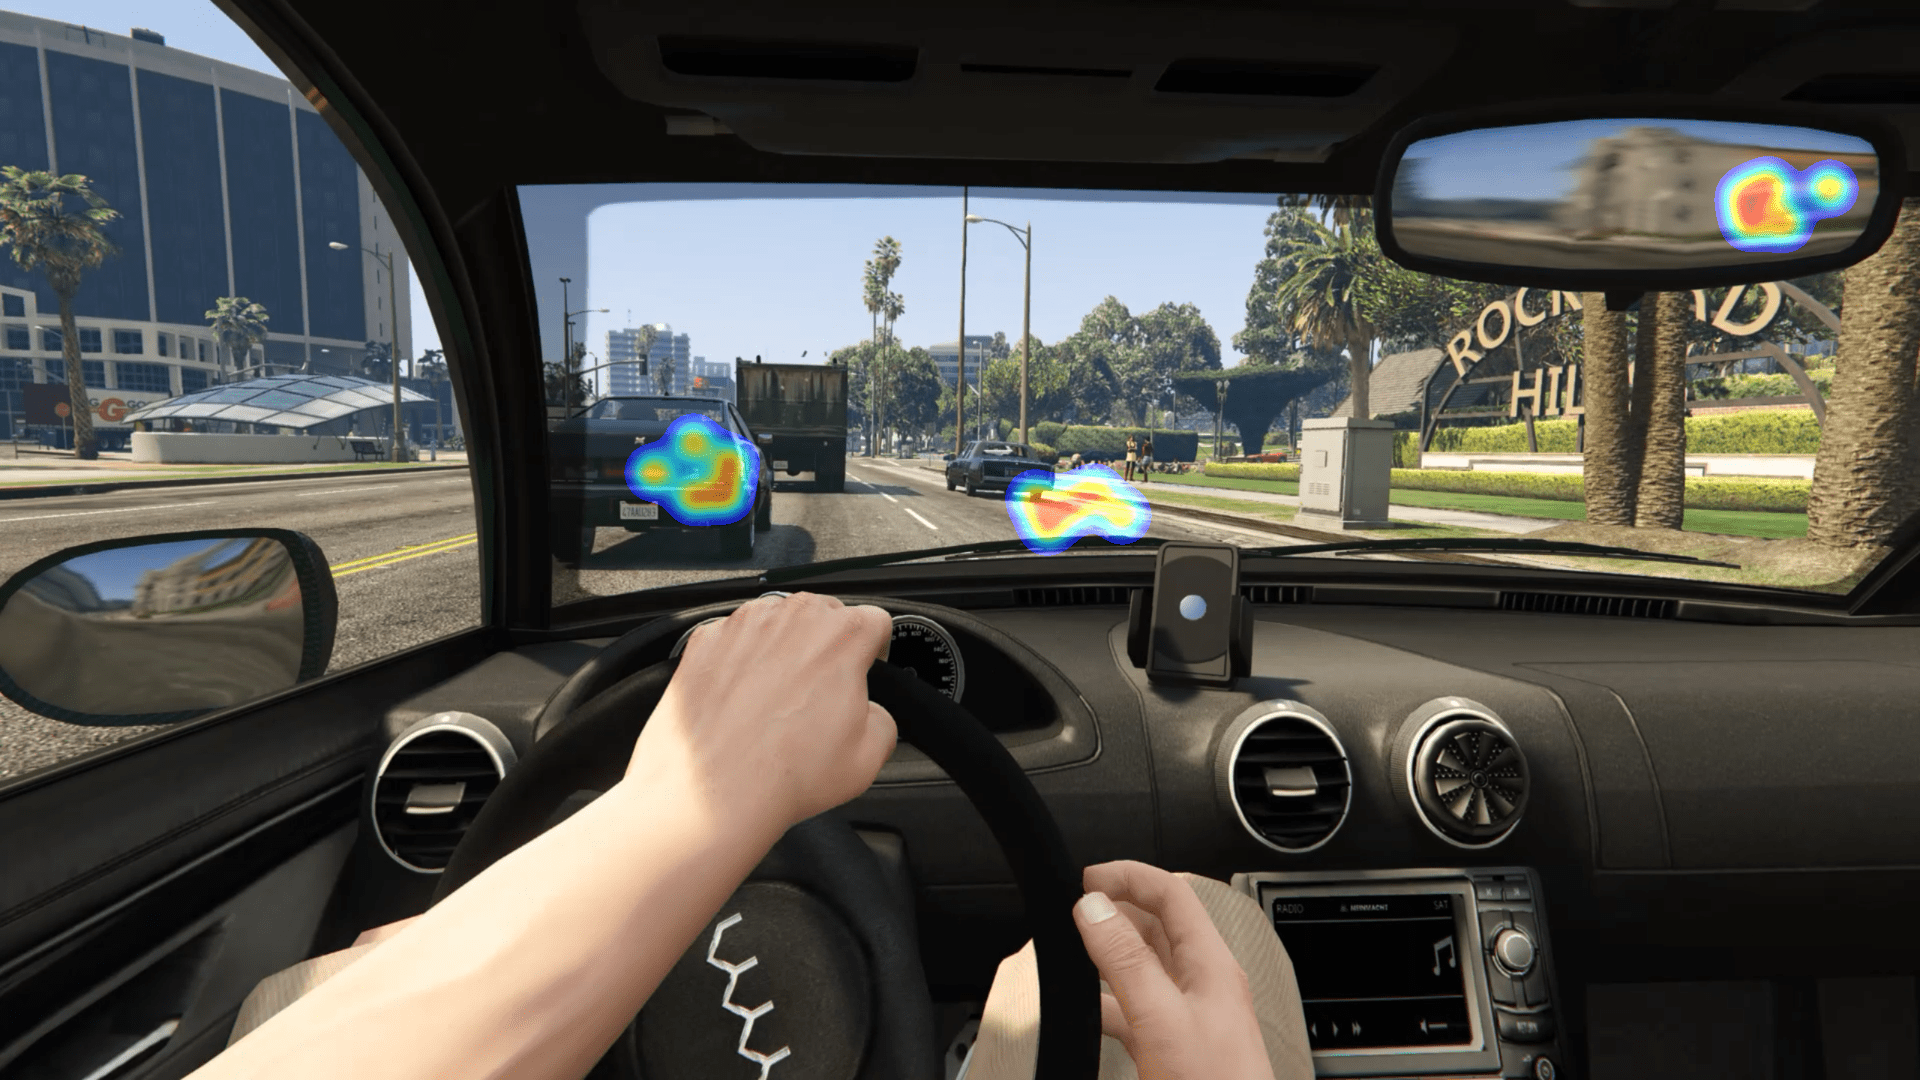

In [26]:
scenarios = ["change_lane", "turn_right-r", "turn_right-l", "dead_zone", "dazzle", "phone"]
scenario = scenarios[0]  # change driving scenario here

chat_history.clear() if scenario not in ["turn_right-r", "turn_right-l"] else None
    
prefix, payload = get_gaze_hmap("base64")
gaze_hmap = prefix + payload
cockpit = obs_cockpit()

print("Data Input:")
print(json.loads(cockpit))
print()
print("Gaze Heatmap Input:")
decode_image(payload)

## Main

In [22]:
result = hcopilot.invoke(
    {
        "data_cockpit": cockpit,
        "data_gaze_hmap": gaze_hmap
    },
    {"configurable": {"session_id": "unused"}}
)


Parent run 29ede551-6f56-407e-9829-35a3da956cae not found for run 32964cfa-70a4-416b-82a8-2c138775342b. Treating as a root run.




> Entering new AgentExecutor chain...

Invoking: `set_camera_to` with `{'entity_id': 'v-001'}`
responded: The human driver is currently controlling the vehicle with the "W" (accelerate) and "D" (turn right) keys pressed. The ego vehicle is moving at a speed of 5.67 m/s with an acceleration of 0.5 m/s², and there is another vehicle (v-001) nearby at a relative distance of 5 meters.

To assist the human driver, I will set the camera to focus on the nearby vehicle (v-001) to provide better situational awareness and generate a speech alert to inform the driver about the nearby vehicle.

Let's proceed with these actions.

(False, 'Error: view to v-001 is unavailable now.')
Invoking: `set_speech` with `{'text': 'Vehicle detected 5 meters ahead. Please proceed with caution.'}`
responded: The human driver is currently controlling the vehicle with the "W" (accelerate) and "D" (turn right) keys pressed. The ego vehicle is moving at a speed of 5.67 m/s with an acceleration of 0.5 m/s², and ther

TrueThe camera could not be set to focus on the nearby vehicle (v-001) due to an error. However, the speech alert has been successfully generated to inform the driver about the nearby vehicle.

Please proceed with caution as there is a vehicle detected 5 meters ahead.

> Finished chain.


### Check Memory

In [27]:
chat_history.messages

[]

### Show Context Awareness

In [24]:
# result_2 = hcopilot.invoke(
#     {
#         "data_cockpit": "what's your last suggestion?",
#         "data_gaze_hmap": gaze_hmap
#     },
#     {"configurable": {"session_id": "unused"}}
# )


In [25]:
# chat_history.messages